<a href="https://colab.research.google.com/github/farazjawedd/Explainable-AI/blob/main/xAI_Assignment_3_Explainable_AI_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI - 590 - Assignment 3 (Faraz Jawed)

## Introduction

## Overview
This notebook demonstrates how to generate local explanations for predictions made by a BERT model using LIME. We'll use a BERT model fine-tuned for sentiment analysis and explain why it makes specific predictions.


In [25]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
torch.manual_seed(42)


In [27]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [28]:
labels = ['1 star', '2 stars', '3 stars', '4 stars', '5 stars']

In [46]:
def predict_proba(texts):
    """
    Predict probability distribution over classes for given texts

    Args:
        texts: List of text strings to classify

    Returns:
        numpy array of shape (n_samples, n_classes)
    """
    # Tokenize all texts in batch
    encoded = tokenizer(texts,
                       padding=True,
                       truncation=True,
                       max_length=512,
                       return_tensors='pt')

    # Get model predictions
    with torch.no_grad():
        outputs = model(**encoded)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    return probs.numpy()

def visualize_explanation(text, exp, pred_class):
    """
    Visualize LIME explanation

    Args:
        text: Original text string
        exp: LIME explanation object
        pred_class: Predicted class index
    """
    # Get word importance scores
    words = text.split()
    word_scores = [0] * len(words)
    for word, score in exp.as_list():
        try:
            idx = words.index(word)
            word_scores[idx] = score
        except ValueError:
            continue
    plt.figure(figsize=(15, 3))
    sns.barplot(x=range(len(words)), y=word_scores)
    plt.xticks(range(len(words)), words, rotation=45, ha='right')
    plt.title(f'Word Importance for Prediction: {labels[pred_class]}')
    plt.xlabel('Words')
    plt.ylabel('Importance Score')
    plt.tight_layout()
    plt.show()


def visualize_text_explanation(text, exp, pred_class):
    """
    Create a more readable visualization of word importances

    Args:
        text: Original text string
        exp: LIME explanation object
        pred_class: Predicted class index
    """
    # Get word importance pairs and sort by position in text
    word_imp = exp.as_list()
    words = text.split()

    # Create lists for visualization
    explained_words = []
    scores = []

    # Match words with their importance scores
    for word in words:
        score = 0.0
        for exp_word, imp in word_imp:
            if exp_word == word:
                score = imp
                break
        explained_words.append(word)
        scores.append(score)

    # Create figure and axis
    plt.figure(figsize=(15, 4))

    # Create bar plot
    bars = plt.bar(range(len(explained_words)), scores)

    # Color bars based on scores
    for bar, score in zip(bars, scores):
        if score > 0:
            bar.set_color('green')
        else:
            bar.set_color('red')

    # Customize plot
    plt.xticks(range(len(explained_words)), explained_words, rotation=45, ha='right')
    plt.xlabel('Words')
    plt.ylabel('Importance Score')
    plt.title(f'Word Importance for Prediction: {labels[pred_class]}')

    # Add grid for better readability
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Show plot
    plt.show()

    # Print text with highlighted words
    print("\nWord importance breakdown:")
    for word, score in zip(explained_words, scores):
        if abs(score) > 0.01:  # Only show words with non-zero importance
            print(f"{word}: {score:.3f}")

In [34]:
explainer = LimeTextExplainer(class_names=labels)

# Generate explanation
exp = explainer.explain_instance(
    text,
    predict_proba,
    num_features=6,
    num_samples=1000
)

Predicted sentiment: 1 star

Prediction probabilities:
1 star: 0.471
2 stars: 0.463
3 stars: 0.063
4 stars: 0.003
5 stars: 0.001


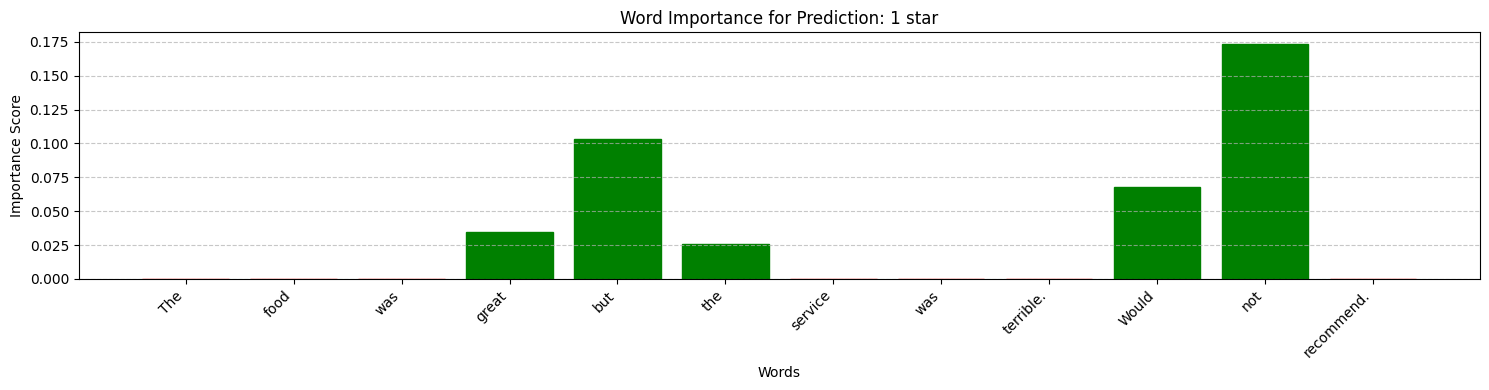


Word importance breakdown:
great: 0.035
but: 0.104
the: 0.026
Would: 0.068
not: 0.173


In [47]:
text = "The food was great but the service was terrible. Would not recommend."

# Get model prediction
probs = predict_proba([text])[0]
pred_class = np.argmax(probs)

print(f"Predicted sentiment: {labels[pred_class]}")
print(f"\nPrediction probabilities:")
for label, prob in zip(labels, probs):
    print(f"{label}: {prob:.3f}")

# Create LIME explainer
explainer = LimeTextExplainer(class_names=labels)

# Generate explanation
exp = explainer.explain_instance(
    text,
    predict_proba,
    num_features=6,
    num_samples=1000
)

# Visualize explanation
visualize_text_explanation(text, exp, pred_class)

## Additional Examples - Multiple texts


Analyzing: The movie was absolutely fantastic! Great acting and amazing plot.

Predicted sentiment: 5 stars
Confidence: 0.923


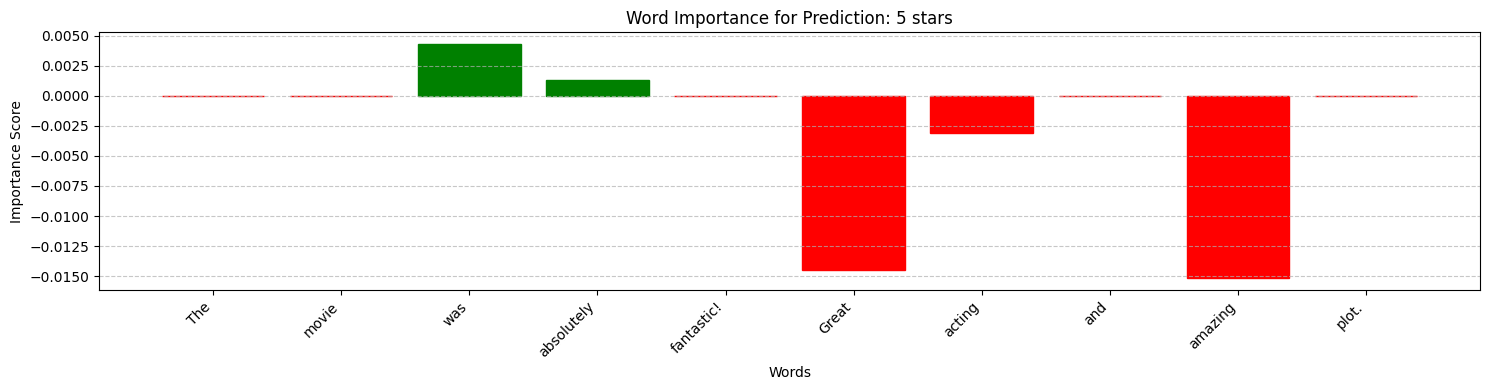


Word importance breakdown:
Great: -0.014
amazing: -0.015

Analyzing: It was okay, nothing special but not bad either.

Predicted sentiment: 3 stars
Confidence: 0.858


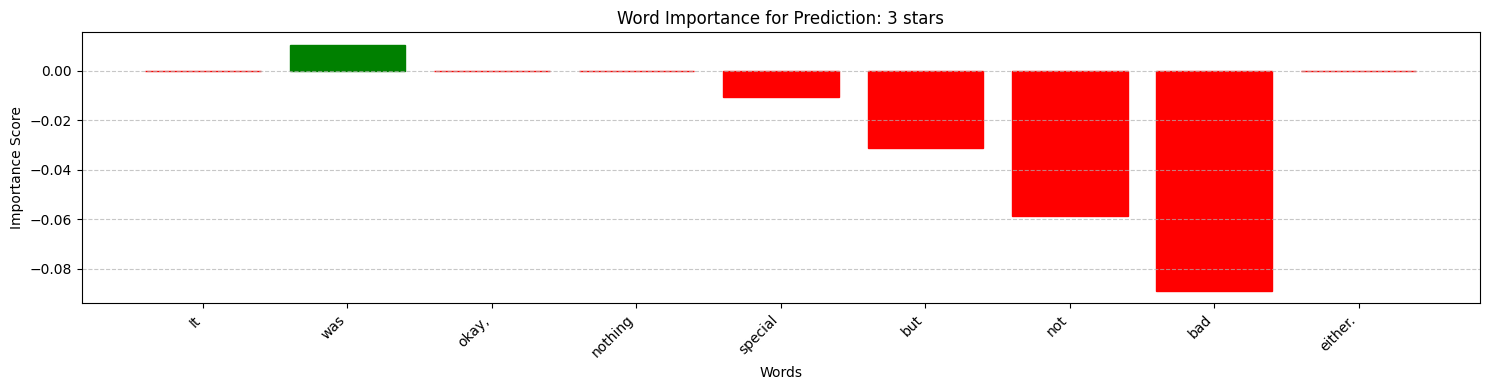


Word importance breakdown:
was: 0.011
special: -0.011
but: -0.031
not: -0.059
bad: -0.089

Analyzing: Worst experience ever. Complete waste of money.

Predicted sentiment: 1 star
Confidence: 0.951


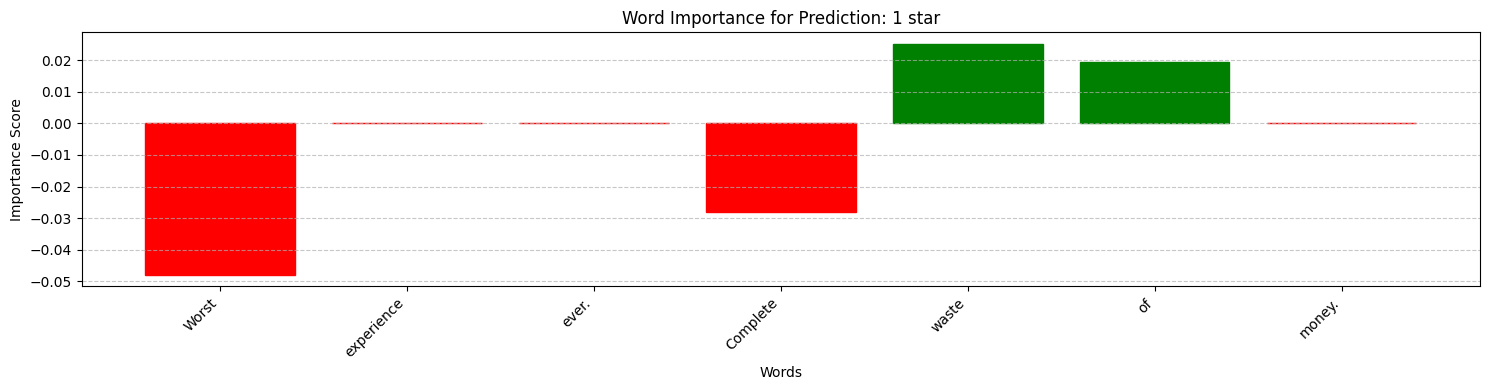


Word importance breakdown:
Worst: -0.048
Complete: -0.028
waste: 0.025
of: 0.019


In [48]:
def analyze_multiple_texts(texts):
    """Analyze and visualize explanations for multiple texts"""
    for text in texts:
        print("\n" + "="*80)
        print(f"Analyzing: {text}")
        print("="*80)

        # Get prediction
        probs = predict_proba([text])[0]
        pred_class = np.argmax(probs)

        print(f"\nPredicted sentiment: {labels[pred_class]}")
        print(f"Confidence: {probs[pred_class]:.3f}")

        exp = explainer.explain_instance(
            text,
            predict_proba,
            num_features=6,
            num_samples=1000
        )

        # Visualize
        visualize_text_explanation(text, exp, pred_class)

sample_texts = [
    "The movie was absolutely fantastic! Great acting and amazing plot.",
    "It was okay, nothing special but not bad either.",
    "Worst experience ever. Complete waste of money."
]

analyze_multiple_texts(sample_texts)


## Discussion: Choice of Explanation Technique

For this assignment, I chose to use LIME (Local Interpretable Model-agnostic Explanations) for explaining BERT predictions for several reasons:

1. Token-level Insights: LIME provides word-level importance scores, which is particularly valuable for understanding how BERT processes text and makes decisions.

2. Model Agnosticity: LIME works without requiring access to the model's internal architecture, making it ideal for explaining black-box models like BERT.

3. Probabilistic Understanding: The explanations show how different words contribute to the probability distribution across all possible classes.

### Strengths:
- Provides intuitive word-level importance scores
- Works with any text classification model
- Can handle complex language models like BERT
- Explains predictions in terms of original text features (words)

### Limitations:
1. Context Loss: LIME treats words independently, potentially missing important contextual relationships that BERT uses
2. Sampling Variance: Different runs can produce slightly different explanations
3. Computation Time: Generating explanations requires multiple model forward passes

### Potential Improvements:
1. Enhanced Analysis:
   - Add support for analyzing word pairs or phrases
   - Incorporate attention weights from BERT
   - Compare explanations across different languages

2. Visualization Enhancements:
   - Add interactive visualizations
   - Show attention patterns alongside LIME explanations
   - Visualize explanations for multiple classes simultaneously

3. Robustness:
   - Implement confidence intervals for explanations
   - Add stability metrics across multiple runs
   - Compare with other explanation techniques (e.g., SHAP)

## References
1. BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding
2. Ribeiro, M. T., Singh, S., & Guestrin, C. (2016). "Why Should I Trust You?": Explaining the Predictions of Any Classifier
3. Transformers library documentation: https://huggingface.co/docs/transformers/
4. LIME documentation: https://lime-ml.readthedocs.io/

---------

AI Usage: I used claude to for the visualization (bar chart code)